# Problem Statement

## Executive Summary 

## Contents:

- **[Import Libraries](#Import-Libraries)**. 

- **[Loading Data](#Loading-Data)**. 
    
- **[Data Cleaning & EDA](#Data-Cleaning-Exploratory-Data-Analysis)**.  


- **[Word Vectorizer](#Word-Vectorizer)**.  

- **[Tweet Vectorizer](#Tweet-Vectorizer)**. 


- **[Model Preparation](#Model-Preparation)**. 

 - **[Modeling](#Modeling)**.   
 
   - **[K-Means](#K-Means)**.  
        - **[K Means Clustering with NLTK Library](#K-Means-Clustering-with-NLTK-Library)**.  
        - **[K Means Clustering with Scikit-learn Library](#K-Means-Clustering-with-Scikit-learn-Library)**. 
   - **[DBSCAN](#DBSCAN)**.    
   
- **[Model Evaluation](#Model-Evaluation)**.  

- **[Conclusions and Recommendations](#Conclusions-and-Recommendations)**.  

- **[References](#References)**.

### Importing Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
import re
from gensim.models.word2vec import Word2Vec 
from nltk.tokenize import RegexpTokenizer 
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
tokenizer = TweetTokenizer()
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.cluster import KMeansClusterer
import nltk

#from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN , KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

#from sklearn.datasets import make_blobs
#from sklearn.linear_model import LogisticRegression
#from sklearn.decomposition import PCA

RANDOM_STATE = 7777
%matplotlib inline


### Loading Data

In [3]:
df = pd.read_csv("../adam/datasets/scrape_5.12.csv")

df.head()

,tweet_id,username,text,tweet_date,search_term,city,lat,long,radius,query_start
0,1234258409408602118,e.p.c.,"Did the first of several shopping runs, though...",2020-03-01 23:25:10,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01
1,1234253374725459968,@geminiwoe,Looks like adios muchachos for the US #COVID #...,2020-03-01 23:05:10,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01
2,1234241890700218370,enigma4ever 🌹🆘 🌊 🕊️🍑👩‍⚕️💉😷,Humour..snl...on #COVID #coronavirususahttps:/...,2020-03-01 22:19:32,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01
3,1234238588474331136,° ° °,had to go to three diff convenient stores to f...,2020-03-01 22:06:25,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01
4,1234238537068883968,enigma4ever 🌹🆘 🌊 🕊️🍑👩‍⚕️💉😷,"#COVID #Coronovirius in nursing home setting ,...",2020-03-01 22:06:12,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01


In [4]:
df.drop_duplicates(inplace = True)

In [5]:
df.shape

(114044, 10)

### Data Cleaning & EDA.

In [7]:
df['text'] = df['text'].astype(str).str.lower()
df['token_text'] = df['text'].str.replace('([^ a-zA-Z0-9])', '').str.replace('http\S+|www.\S+', '', case=False).replace('coronavirus', 'covid19')

stop = stopwords.words('english')
df['stop_text'] = df['token_text'].apply(lambda x: [item for item in str(x).split() 
                                                    if item not in stop])

In [8]:
df['text'].head()

0    did the first of several shopping runs, though...
1    looks like adios muchachos for the us #covid #...
2    humour..snl...on #covid #coronavirususahttps:/...
3    had to go to three diff convenient stores to f...
4    #covid #coronovirius in nursing home setting ,...
Name: text, dtype: object

In [9]:
df['stop_text'].head()

0    [first, several, shopping, runs, though, ended...
1    [looks, like, adios, muchachos, us, covid, cov...
2                 [humoursnlon, covid, coronavirususa]
3    [go, three, diff, convenient, stores, find, re...
4    [covid, coronovirius, nursing, home, setting, ...
Name: stop_text, dtype: object

In [10]:
df['token_text'].head()

0    did the first of several shopping runs though ...
1    looks like adios muchachos for the us covid co...
2                     humoursnlon covid coronavirususa
3    had to go to three diff convenient stores to f...
4    covid coronovirius in nursing home setting  ki...
Name: token_text, dtype: object

### Word Vectorizer

In [11]:
sent = [row for row in df['stop_text']]

In [12]:
tweet_w2v = Word2Vec(size=1000, min_count=100, window=10)

In [13]:
tweet_w2v.build_vocab(sent)

In [14]:
tweet_w2v.most_similar('positive')

[('ser', 0.10352224111557007),
 ('google', 0.10276614129543304),
 ('knowledge', 0.0962667167186737),
 ('hear', 0.09062155336141586),
 ('racism', 0.08931808918714523),
 ('dead', 0.08905940502882004),
 ('internet', 0.08730019629001617),
 ('wash', 0.0856761783361435),
 ('ahead', 0.0846472829580307),
 ('outside', 0.08437663316726685)]

In [15]:
#df.isnull().sum()

In [16]:
#df = df.dropna() #droping null rows

In [17]:
#df.isnull().sum().sum()

In [18]:
#df.shape

### Tweet Vectorizer

In [19]:
# Functions found in this cell were created by instructor Noah C
# He is great
# Define vectorization function
#word2vecmodel = tweet_w2v
def vectorize_corpus(keyword_list):    
    # Instantiate counter for number of words in keyword_list that exists
    n_words = 0
    # Create template for cumulative corpus vector sum
    corpus_vec_sum = np.zeros((1,1000))                 
    # Scan through each word in list
    for word in keyword_list:
        if word in tweet_w2v.wv.vocab:                    
            word_vec = tweet_w2v.wv.word_vec(word)
            #print(word_vec)
            n_words +=1                                
            corpus_vec_sum = corpus_vec_sum + word_vec 
    # Compute average vector by taking cumulative vector sum and dividing it by number of words traced
    corpus_avg_vec = corpus_vec_sum/n_words
    # Squeeze this N-dimensional nested array object into a 1-D array to streamline future processing
    corpus_avg_vec = np.squeeze(corpus_avg_vec)
    return(corpus_avg_vec)
#defining cosine similarity function
def cos_sim(vector_1, vector_2):
    dp = np.dot(vector_1, vector_2)
    magnitude_v1 = np.sqrt(np.dot(vector_1,vector_1))
    magnitude_v2 = np.sqrt(np.dot(vector_2,vector_2))
    return(dp/(magnitude_v1*magnitude_v2))

In [20]:
vect_tweets = [vectorize_corpus(tweet) for tweet in df['stop_text']]
vect_df = pd.DataFrame(vect_tweets)

In [21]:
#vect_df

In [59]:
#vect_df = vect_df.fillna(vect_df.mean())

In [22]:
print(df.shape)
print(vect_df.shape)

(114044, 12)
(114044, 1000)


In [23]:
join_df = df.join(vect_df)
join_df.dropna(inplace = True)
join_df.shape

(107799, 1012)

In [24]:
clean_vec_df= join_df.iloc[:, [i for i in range(13,1012)]]
clean_og_df = join_df.iloc[:, [i for i in range(0,12)]]
clean_vec_df.head()

,1,2,3,4,5,6,7,8,9,10,...,990,991,992,993,994,995,996,997,998,999
0,-0.000054,0.000025,-1.667924e-05,0.000011,-0.000015,-0.000007,0.000042,-0.000060,0.000041,-0.000036,...,-0.000168,0.000059,0.000019,-0.000108,0.000059,-0.000054,0.000165,0.000023,-0.000021,0.000074
1,0.000136,-0.000019,1.443993e-04,-0.000042,-0.000049,-0.000066,-0.000135,-0.000029,0.000121,-0.000223,...,-0.000047,-0.000083,0.000084,0.000064,-0.000033,0.000129,0.000090,-0.000082,-0.000047,0.000105
2,0.000036,0.000148,2.978641e-06,-0.000239,0.000020,0.000337,-0.000077,0.000022,0.000054,-0.000230,...,-0.000109,-0.000264,0.000012,0.000272,-0.000157,-0.000172,-0.000081,0.000246,0.000042,-0.000209
3,0.000010,-0.000109,2.119401e-08,0.000084,0.000100,-0.000046,0.000004,-0.000082,-0.000038,-0.000073,...,-0.000062,0.000048,0.000096,0.000052,-0.000015,0.000002,0.000002,0.000138,-0.000061,-0.000034
4,0.000069,0.000008,3.158759e-05,-0.000098,-0.000006,0.000148,-0.000278,0.000056,-0.000050,-0.000206,...,-0.000085,0.000032,0.000012,0.000024,0.000003,0.000124,-0.000067,-0.000202,0.000163,0.000007


In [25]:
clean_og_df.head()

,tweet_id,username,text,tweet_date,search_term,city,lat,long,radius,query_start,token_text,stop_text
0,1234258409408602118,e.p.c.,"did the first of several shopping runs, though...",2020-03-01 23:25:10,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,did the first of several shopping runs though ...,"[first, several, shopping, runs, though, ended..."
1,1234253374725459968,@geminiwoe,looks like adios muchachos for the us #covid #...,2020-03-01 23:05:10,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,looks like adios muchachos for the us covid co...,"[looks, like, adios, muchachos, us, covid, cov..."
2,1234241890700218370,enigma4ever 🌹🆘 🌊 🕊️🍑👩‍⚕️💉😷,humour..snl...on #covid #coronavirususahttps:/...,2020-03-01 22:19:32,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,humoursnlon covid coronavirususa,"[humoursnlon, covid, coronavirususa]"
3,1234238588474331136,° ° °,had to go to three diff convenient stores to f...,2020-03-01 22:06:25,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,had to go to three diff convenient stores to f...,"[go, three, diff, convenient, stores, find, re..."
4,1234238537068883968,enigma4ever 🌹🆘 🌊 🕊️🍑👩‍⚕️💉😷,"#covid #coronovirius in nursing home setting ,...",2020-03-01 22:06:12,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,covid coronovirius in nursing home setting ki...,"[covid, coronovirius, nursing, home, setting, ..."


### Model Preparation

In [26]:
#X = tweet_w2v[tweet_w2v.wv.vocab]
X = clean_vec_df

### Modeling

#### K-Means 

##### K Means Clustering with NLTK Library

In [28]:
# NUM_CLUSTERS=4
# kclusterer = KMeansClusterer(NUM_CLUSTERS, 
#                              distance=nltk.cluster.util.cosine_distance,
#                              avoid_empty_clusters=True,
#                              repeats=25)
# assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

In [29]:
# words = list(tweet_w2v.wv.vocab)
# for i, word in enumerate(words):
#     print (str(word + ":" + str(assigned_clusters[i]))

##### K Means Clustering with Scikit-learn Library

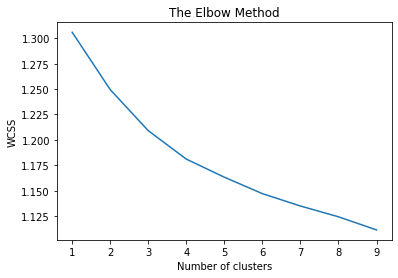

In [39]:
# #Fit a k-means clustering model
# km = KMeans(n_clusters= NUM_CLUSTERS,
#             random_state=2020)
# #fitting model
# km.fit(X)

#within cluster sum of squares(wcss)
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init='k-means++',
                    n_init=10,
                   random_state= RANDOM_STATE)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,10), wcss)
plt.title('The Elbow Method')
plt.xlabel("Number of clusters")
plt.ylabel('WCSS')
plt.show()

In [45]:
clean_og_df['KMeans_cluster'] = kmeans.labels_

In [46]:
clean_og_df['KMeans_cluster'].value_counts()

2    57712
3    15301
6    13291
1     6544
5     6146
8     4277
4     2002
7     1487
0     1039
Name: KMeans_cluster, dtype: int64

In [50]:
mask = clean_og_df['KMeans_cluster'] == 3

In [51]:
clean_og_df[mask].tail()

,tweet_id,username,text,tweet_date,search_term,city,lat,long,radius,query_start,token_text,stop_text,cluster,KMeans_cluster
113929,1254484714645266432,LI Sports Fan,yikes! that is definitely not social distanci...,2020-04-26 18:57:17,COVID,NYC,40.9634,-72.1848,35mi,2020-01-01,yikes that is definitely not social distancin...,"[yikes, definitely, social, distancing, dont, ...",-1,3
113937,1253816667160875012,Ide M Koulbanis,thank you @alanbetson for this! i look forward...,2020-04-24 22:42:42,COVID,NYC,40.9634,-72.1848,35mi,2020-01-01,thank you alanbetson for this i look forward t...,"[thank, alanbetson, look, forward, reading, se...",8195,3
113982,1251958285487439872,Tommy D. Monroe,another vicious problem solved by wonderful co...,2020-04-19 19:38:10,COVID,NYC,40.9634,-72.1848,35mi,2020-01-01,another vicious problem solved by wonderful co...,"[another, vicious, problem, solved, wonderful,...",8668,3
113989,1251847865133129728,Xanax! At The Disco,a helpful update to that book you insist on us...,2020-04-19 12:19:23,COVID,NYC,40.9634,-72.1848,35mi,2020-01-01,a helpful update to that book you insist on us...,"[helpful, update, book, insist, using, instead...",8677,3
114022,1250923991801434113,Mr. Ankrum,dear @joebiden im a #republican whose 100% goi...,2020-04-16 23:08:15,COVID,NYC,40.9634,-72.1848,35mi,2020-01-01,dear joebiden im a republican whose 100 going ...,"[dear, joebiden, im, republican, whose, 100, g...",8476,3


In [42]:
kmeans.cluster_centers_

array([[-5.41738490e-05, -1.30921093e-04, -1.36516817e-04, ...,
         1.77901519e-04, -1.91387580e-04, -1.09623672e-04],
       [ 7.01956933e-05,  6.78069779e-05,  3.78541714e-05, ...,
         5.30208049e-05,  1.64560771e-05, -4.82116981e-05],
       [ 4.25685185e-05,  1.40962395e-05,  7.45946206e-06, ...,
         9.06921974e-06, -2.40479452e-05,  1.85731664e-05],
       ...,
       [ 1.88349393e-05, -3.43577448e-05, -1.90606699e-05, ...,
         5.51563813e-05, -5.51784895e-05, -2.53698424e-05],
       [ 4.94859315e-05,  1.77109199e-05,  3.06019202e-04, ...,
         1.27386959e-04, -3.63023229e-04, -4.77339157e-05],
       [ 1.30705316e-04, -7.24790590e-05,  5.88623261e-05, ...,
        -7.72272953e-05,  3.55942351e-07,  2.57347128e-06]])

In [32]:
#sum of squared errors for each cluster.
print("Inertia: ", kmeans.inertia_)

Inertia:  1.2090908241165


In [33]:
#Silhouette Score
print("Silhouette Score: ", silhouette_score(X, kmeans.labels_))

Silhouette Score:  0.16655744723263222


#### DBSCAN

In [34]:
dbscan = DBSCAN(metric='cosine', 
                eps=0.01, 
                min_samples=3, 
                n_jobs = 1) 
cluster_labels = dbscan.fit_predict(X) 

In [35]:
print("Silhoutte Score : ", silhouette_score(X, dbscan.labels_))

Silhoutte Score :  0.2619705580008748


In [44]:
clean_og_df['cluster'] = cluster_labels

In [37]:
clean_og_df['cluster'].value_counts()

-1       60577
 16        577
 4713      322
 177       120
 1062      108
         ...  
 8692        3
 7638        3
 2609        3
 6707        3
 6841        3
Name: cluster, Length: 8776, dtype: int64

In [38]:
clean_og_df.head(5)

,tweet_id,username,text,tweet_date,search_term,city,lat,long,radius,query_start,token_text,stop_text,cluster
0,1234258409408602118,e.p.c.,"did the first of several shopping runs, though...",2020-03-01 23:25:10,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,did the first of several shopping runs though ...,"[first, several, shopping, runs, though, ended...",0
1,1234253374725459968,@geminiwoe,looks like adios muchachos for the us #covid #...,2020-03-01 23:05:10,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,looks like adios muchachos for the us covid co...,"[looks, like, adios, muchachos, us, covid, cov...",1
2,1234241890700218370,enigma4ever 🌹🆘 🌊 🕊️🍑👩‍⚕️💉😷,humour..snl...on #covid #coronavirususahttps:/...,2020-03-01 22:19:32,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,humoursnlon covid coronavirususa,"[humoursnlon, covid, coronavirususa]",2
3,1234238588474331136,° ° °,had to go to three diff convenient stores to f...,2020-03-01 22:06:25,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,had to go to three diff convenient stores to f...,"[go, three, diff, convenient, stores, find, re...",3
4,1234238537068883968,enigma4ever 🌹🆘 🌊 🕊️🍑👩‍⚕️💉😷,"#covid #coronovirius in nursing home setting ,...",2020-03-01 22:06:12,COVID,Brooklyn,40.650002,-73.949997,10mi,2020-02-01,covid coronovirius in nursing home setting ki...,"[covid, coronovirius, nursing, home, setting, ...",4


### Model Evaluation

### Conclusions and Recommendations

### References